In [2]:
import os
import os.path
import numpy as np
import datetime
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import pandas as pd

In [34]:
#Handle data
market_simulator = pd.read_csv(
    '/Users/oscarpeyron/Downloads/012_Quick_Acess/S&P500_index1Y.csv',
    parse_dates=['Datum'],  # Parse 'Datum' as datetime
    index_col='Datum'       # Set 'Datum' as the index
).dropna()


market_simulator["Average_SP_Index"] = (market_simulator["Hoch"] + market_simulator["Tief"]) / 2
market = market_simulator["Average_SP_Index"].iloc[::-1]

# Compute log returns
market_log_returns = np.log(market).diff().dropna()
market_log_returns = (market_log_returns - market_log_returns.mean()) / market_log_returns.std()

print(market_log_returns)


Datum
2020-01-30   -0.589118
2020-01-31   -0.518353
2020-02-03    0.058685
2020-02-04    1.187489
2020-02-05    0.886538
                ...   
2025-01-22    0.900577
2025-01-23    0.083880
2025-01-24    0.139689
2025-01-27   -1.942885
2025-01-28    0.670540
Name: Average_SP_Index, Length: 1256, dtype: float64


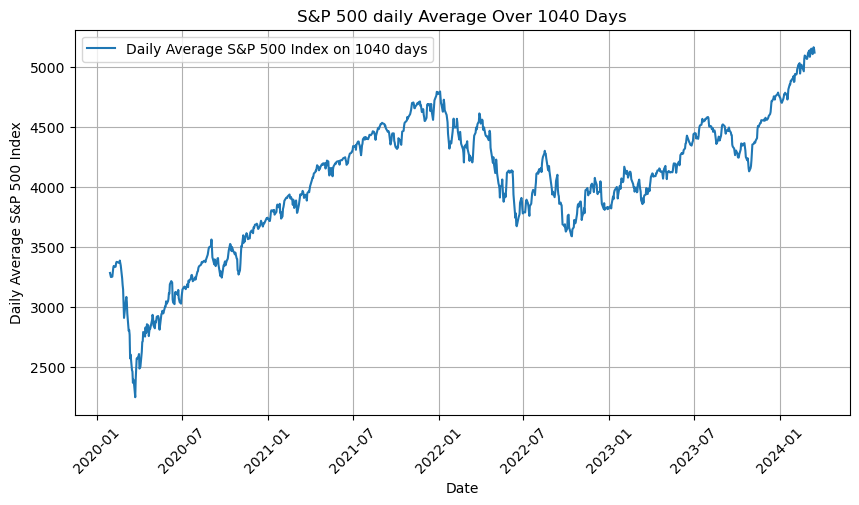

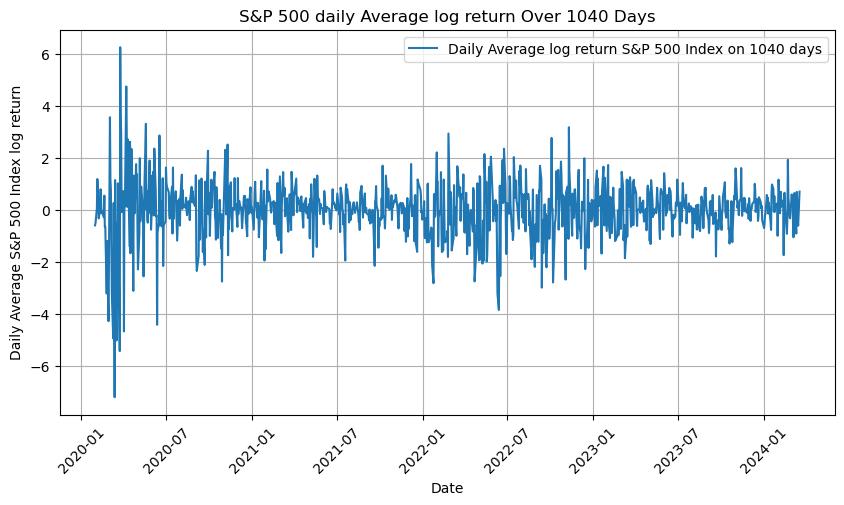

In [35]:
#S&P 500 Market Simulator (Non-stationary market)

t =  0
T = 1040
market_plot = market[t:T]
market_return_plot = market_log_returns[t:T]

# Plot market
plt.figure(figsize=(10, 5))
plt.plot(market_plot.index, market_plot.values, linestyle='-', label=f"Daily Average S&P 500 Index on {T-t} days")
# Formatting
plt.xlabel("Date")
plt.ylabel("Daily Average S&P 500 Index")
plt.title(f"S&P 500 daily Average Over {T-t} Days")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.legend()

#Plot market returns 
plt.figure(figsize=(10, 5))
plt.plot(market_return_plot.index, market_return_plot.values, linestyle='-', label=f"Daily Average log return S&P 500 Index on {T-t} days")

#Formatting
plt.xlabel("Date")
plt.ylabel("Daily Average S&P 500 Index log return")
plt.title(f"S&P 500 daily Average log return Over {T-t} Days")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.legend()

plt.show()

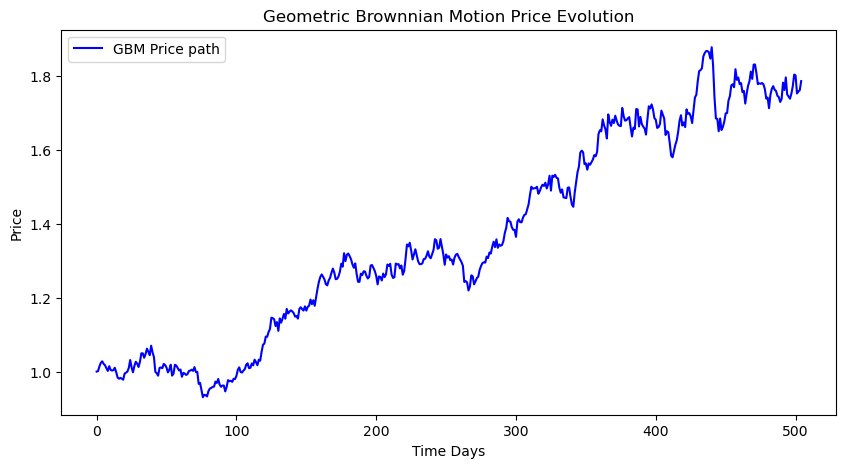

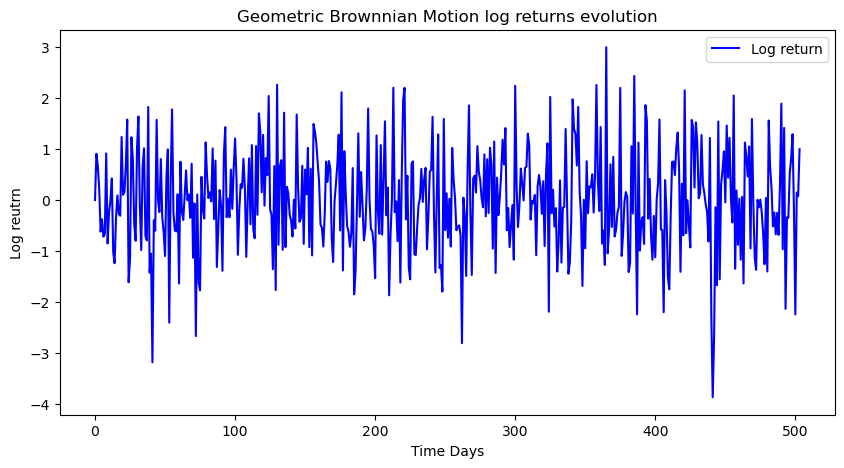

In [105]:
#Market simulation stationary market :

# Parameters
T = 2          # Total years
N = 252 * T    # Number of trading days
dt = 1 / 252   # Time step (daily)
mu = 0.10 # Annual drift (10%)
sigma = 0.20   # Annual volatility (20%)
P0 = 1         # Initial price

# Generate Brownian motion
dW = np.random.normal(0, np.sqrt(dt), N)  # Brownian increments

# Compute the price process using the GBM formula
P = np.zeros(N+1)
P[0] = P0
for t in range(1, N+1):
    P[t] = P[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW[t-1])

# Convert to numpy array
P_array = np.array(P)
log_returns = np.diff(np.log(P_array))
market_log_returns = (log_returns - log_returns.mean()) / log_returns.std()

#Plot market 
t = np.arange(len(P_array))
plt.figure(figsize=(10, 5))
plt.plot(t, P_array, linestyle='-', label=f"GBM Price path", color ="blue")
# Formatting
plt.xlabel("Time Days")
plt.ylabel("Price")
plt.title("Geometric Brownnian Motion Price Evolution")
plt.legend()


# Plot market log returns 
t= np.arange(len(log_returns))
plt.figure(figsize=(10, 5))
plt.plot(t, market_log_returns, linestyle='-', label=f"Log return", color ="blue")
# Formatting
plt.xlabel("Time Days")
plt.ylabel("Log reutrn")
plt.title("Geometric Brownnian Motion log returns evolution")
plt.legend()




In [106]:
import numpy as np
import random

def emv_portfolio_selection(
    market_simulator, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
):
    # Extract parameters
    alpha, eta_kappa, eta_phi = learning_rates
    x_0 = initial_wealth  
    z = target_payoff
    T, delta_t = investment_horizon, discretization_dt
    lamb = exploration_rate
    M = num_iterations
    N = sample_average_size
    r= interest_rate #yearly interest rate 

    #initialization of parameters (tuning as best as possible)
    phi = [0,0.1]
    kappa= [-(x_0-z)**2,0,0,2*phi[1]]
    w= x_0

    phi_policy = phi
   
   #helper lists
    D_final = []
    D_final_pi = []
    D_final_value = []

    #return lists
    pay_off_mean = []
    pay_off_mean_non_agg = []
    variance_off_sample = []
    value_sample = [] #value function
    ratio_risky_asset_sample = []
    ratio_risky_over_time = []
    

    for k in range(1, M + 1):
        D = [(0, x_0)]  # Collected samples as tuples (time, wealth)
        D_pi = [0] #Collected samples as tuples (time, risky_allocation)
        D_value = [compute_V(kappa, phi, x_0, w, 0, T)]
        for i in range(1, int(T / delta_t)):

            #simulate the market
            t_k, x_k, theta_k = simulate_market(market_simulator,phi_policy, D, w, T, lamb,delta_t,r)

            pi_k = theta_k * np.exp(r*t_k)/x_k

            value_function_k = compute_V(kappa, phi, x_k, w, t_k, T)
            
            #sample collection
            D.append((t_k, x_k))

            #ratio_risky_asset_collection 
            D_pi.append(pi_k)

            #collection of value_function at t_k 
            D_value.append(value_function_k)

            # Compute Bellman error
            delta_t_error = compute_bellman_error(kappa, phi, D, w, T, lamb, delta_t)
            
            # Compute gradients (Equations 48-51)
            grad_kappa_1 = compute_grad_kappa_1(kappa, phi, D, w, T, lamb, delta_t)
            grad_kappa_2 = compute_grad_kappa_2(kappa, phi, D, w, T, lamb, delta_t)
            grad_phi_1   = compute_grad_phi_1(kappa, phi, D, w, T, lamb, delta_t)
            grad_phi_2   = compute_grad_phi_2(kappa, phi, D, w, T, lamb, delta_t)

            # Update parameters
            kappa[1] -= eta_kappa * grad_kappa_1
            kappa[2] -= eta_kappa * grad_kappa_2

            # Update kappa[3] and kappa[0] explicitly
            kappa[3] = 2 * phi[1]      # kappa₃ = 2φ₂
            kappa[0] = -kappa[2] * T**2 - kappa[1] * T - (w - z)**2

            #update phi
            phi[0]   -= eta_phi * grad_phi_1
            phi[1]   -= eta_phi * grad_phi_2
        
        #update the policy_phi
        phi_policy[0] = phi[0]
        phi_policy[1] = phi[1]

        #get all the values of x^j_{T/delta} for j in 1 to M 
        D_final.append(D[-1][1]) 

        #get all the values of pi^j_{T/delta}    
        D_final_pi.append(D_pi[-1])

        #get all the values of V_j(T/delta) for j  in 1 to M 
        D_final_value.append(D_value[-1])


        if k == M: 
            ratio_risky_over_time = D_pi
            
        # Update Lagrange multiplier every N iterations (Equation 52)
        if k % N == 0:
            #to plot aggregated mean
            pay_off_mean.append(np.mean([x for x in D_final]))
            recent_samples = D_final[k-N+1:k+1] 
            recent_pi_samples = D_final_pi[k-N+1:k+1]
            recent_value_samples = D_final_value[k-N+1:k+1]

            #compute mean of risky allocations 
            average_terminal_allocation = np.mean([x for x in recent_pi_samples])
        
            #compute mean of value functions 
            average_terminal_value_function = np.mean([x for x in recent_value_samples])

            #compute mean and variance over sample size 
            average_terminal_wealth = np.mean([x for x in recent_samples])
            variance = sum([(x-average_terminal_wealth)**2 for x in recent_samples])

            #append mean of risky allocations
            ratio_risky_asset_sample.append(average_terminal_allocation)

            #append mean of value functions
            value_sample.append(average_terminal_value_function)


            #append mean and variance over sample
            pay_off_mean_non_agg.append(average_terminal_wealth)
            variance_off_sample.append(variance)

            #update of the Lagrange mutiplier omega 
            w -= alpha * (average_terminal_wealth - target_payoff)

    return kappa, phi, w, pay_off_mean, pay_off_mean_non_agg, variance_off_sample, ratio_risky_asset_sample, ratio_risky_over_time, value_sample

def policy_phi(phi_policy, x,t, T,w, lamb): #(checked)
    mean = -np.sqrt(2 * phi_policy[1] / (lamb * np.pi))* np.exp((2*phi_policy[0]-1)/2) * ((x - w))  
    #print("mean", mean)
    variance = (1 / (2 * np.pi)) * np.exp(2 * phi_policy[1]* (T-t) +  (2 * phi_policy[0] - 1))
    #print(variance)
    return np.random.normal(mean,variance)

def simulate_market(market_simulator, phi_policy, D, w, T, lamb, delta_t,r):
    """Simulates the market and returns sampled (t_k, x_k)."""
    t_k, x_k = D[-1] #get the last sample
    theta_k = policy_phi(phi_policy, x_k, t_k, T,w,lamb)
   
   #market return going in 
    dx = market_simulator[int(252*t_k) + 1] #change when going to t_k+1
    x_k = x_k + theta_k*dx + (x_k - theta_k)*r/252 #changed the way one computes the next wealth 
    t_k  += delta_t
    return t_k, x_k, theta_k 

def compute_bellman_error(kappa, phi, D, w, T, lamb, delta_t): #(checked)
    """Computes the Bellman error δ_t (Equation 43)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]  # next time step
        x_i   = D[i][1]
        x_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, phi, x_i, w, t_i, T)
        V_t_1 = compute_V(kappa, phi, x_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t 
        entropy = phi[0] + phi[1] * (T - t_i)
        C += (V_dot - lamb * entropy)**2 * delta_t
    return C / 2

def compute_V(kappa, phi, x, w, t, T): #(checked)
    arg = -kappa[3] * (T - t)
    V_gamma = (x - w)**2 * np.exp(arg) + kappa[2] * t**2 + kappa[1] * t + kappa[0]
    return V_gamma

def compute_grad_kappa_1(kappa, phi, D, w, T, lamb, delta_t):
    """Computes gradient of cost with respect to θ₁ (Equation 48)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        x_i   = D[i][1]
        x_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, phi, x_i, w, t_i, T)
        V_t_1 = compute_V(kappa, phi, x_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t 
        entropy = phi[0] + phi[1] * (T - t_i)
        C += (V_dot - lamb * entropy) *delta_t  
    return C

def compute_grad_kappa_2(kappa, phi, D, w, T, lamb, delta_t):
    """Computes gradient of cost with respect to θ₂ (Equation 49)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        x_i   = D[i][1]
        x_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, phi, x_i, w, t_i, T)
        V_t_1 = compute_V(kappa, phi, x_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t 
        entropy = phi[0] + phi[1] * (T - t_i)
        C += (V_dot - lamb * entropy) * (t_i_1**2 - t_i**2)
    return C

def compute_grad_phi_1(kappa, phi, D, w, T, lamb, delta_t):
    """Computes gradient of cost with respect to φ₁ (Equation 50)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        x_i   = D[i][1]
        x_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, phi, x_i, w, t_i, T)
        V_t_1 = compute_V(kappa, phi, x_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) /delta_t
        entropy = phi[0] + phi[1] * (T - t_i)
        C += (-lamb) * (V_dot - lamb * entropy) * delta_t
    return C

def compute_grad_phi_2(kappa, phi, D, w, T, lamb, delta_t):
    """Computes gradient of cost with respect to φ₂ (Equation 51)."""
    C = 0 
    for i in range(len(D) - 1):
        t_i   = D[i][0]
        t_i_1 = D[i + 1][0]
        x_i   = D[i][1]
        x_i_1 = D[i + 1][1]
        V_t   = compute_V(kappa, phi, x_i, w, t_i, T)
        V_t_1 = compute_V(kappa, phi, x_i_1, w, t_i_1, T)
        V_dot = (V_t_1 - V_t) / delta_t  
        entropy = phi[0] + phi[1] * (T - t_i)
        arg1 = -2 * phi[1] * (T - t_i_1)
        arg2 = -2 * phi[1] * (T - t_i)
        exp_factor_1 = np.exp(arg1)
        exp_factor_2 = np.exp(arg2)
        
        gradient_term = (2 * (x_i_1 - w)**2 * exp_factor_1 * (T - t_i_1) -
                         2 * (x_i - w)**2 * exp_factor_2 * (T - t_i)) / delta_t

        C += (V_dot - lamb * entropy) *  (-gradient_term - lamb * (T - t_i)) * delta_t 
    
    return C


In [ ]:
def feasible_target_return(brownian_return, yearly_interest, horizon):
    target = 0.8 * brownian_return *horizon 
    while target < yearly_interest * horizon:
        target = (target + brownian_return *horizon)   
    return target

0.016000000000000004


Brownian expected annual drift 0.1
Brownian standard annual volatility 0.2
Target payoff 1.0317460317460319
For Market modeled with Brownian Motion
Final Parameters:
kappa: [-0.0027439235048625048, -0.0025229377098481436, -0.0011526096428263084, 4.2626514339516355]
Phi: [0.0005045875419696265, 2.1313344325717924]
w: 1.087378951810778


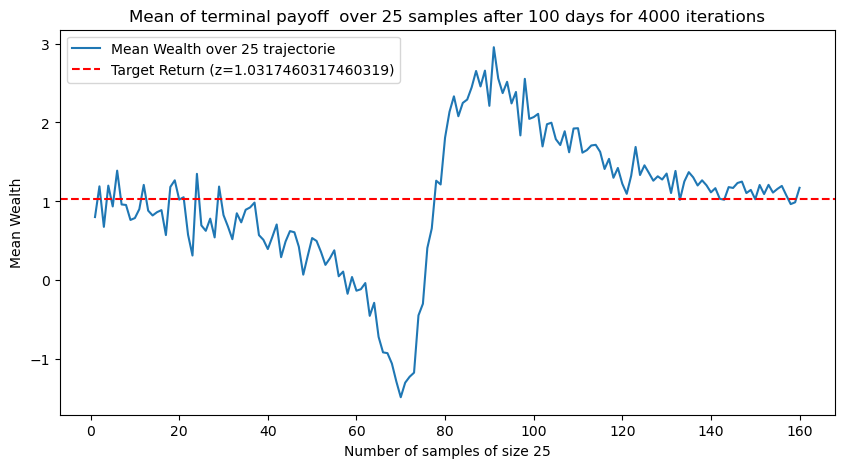

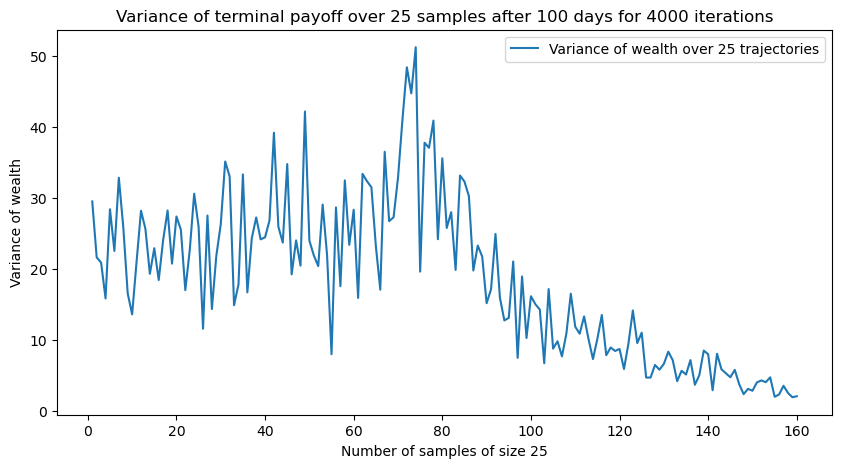

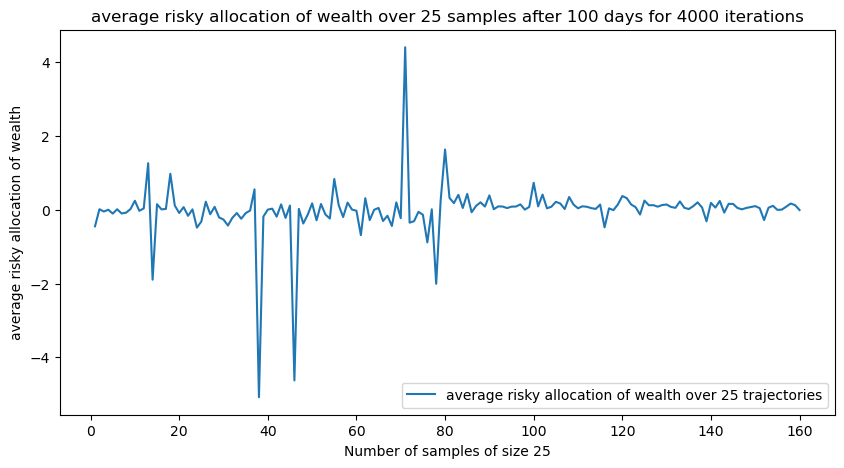

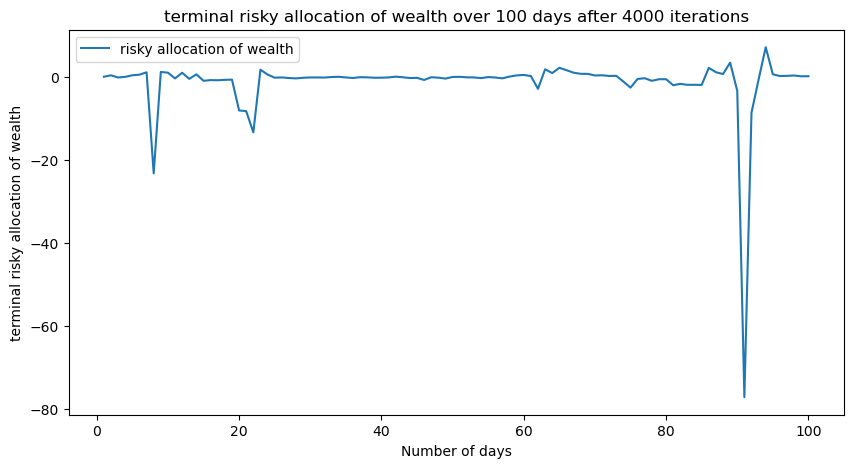

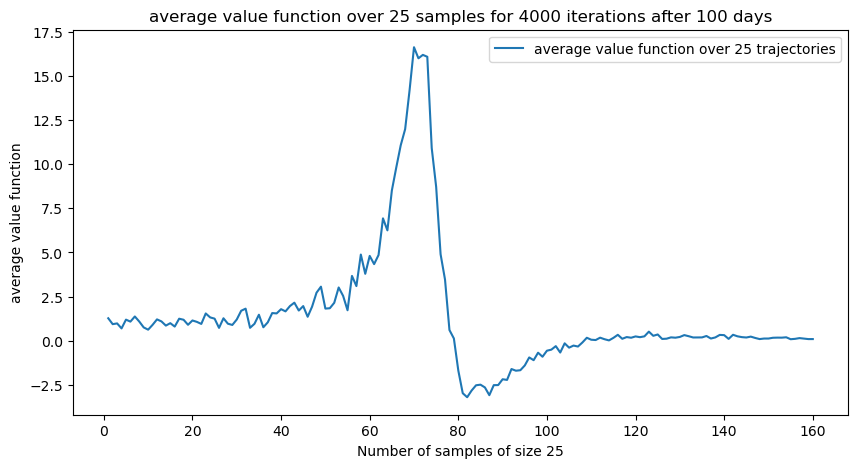

In [107]:
#Market modeled with geomtric Brownian Motion

# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.0000000005)   # (alpha, eta_kappa, eta_phi)
exploration_rate = 2 #lambda
num_iterations = 4000
sample_average_size = 25

#Market and Target parameters
initial_wealth = 1.0
investment_horizon = 100/252 #T
discretization_dt = 1/252 #number of days #delta_t
interest_rate = 0.02

#print param:
print("Brownian expected annual drift", mu)
print("Brownian standard annual volatility", sigma)
print("Annual interest rate", interest_rate)

#we try to take 80% of the maximum return possible for the number of trading days 
target_payoff = 1+ feasible_target_return(mu,interest_rate, investment_horizon)
print("Target payoff", target_payoff)

market_simulator = market_log_returns #simulate using log returns

#calling the function --------------------------------------------------------------
kappa, phi, w, payoff_mean, pay_off_mean_non_agg, variance_off_sample, ratio_risky, ratio_risky_over_time, value_sample = emv_portfolio_selection(
    market_simulator, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
)


print("For Market modeled with Brownian Motion")
print("Final Parameters:")
print("kappa:", kappa)
print("Phi:", phi)
print("w:", w)



#-------------------------------------------- Mean over the sample_average_size------------------------------------------------------------#

#PLOT Mean payoff

num_trajectories = list(range(1, len(pay_off_mean_non_agg) + 1))  # X-axis: trajectory indices

plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, pay_off_mean_non_agg, linestyle='-', label=f'Mean Wealth over {sample_average_size} trajectorie')

plt.axhline(y=target_payoff, color='r', linestyle='--', label=f'Target Return (z={target_payoff})')

plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Mean Wealth")
plt.title(f"Mean of terminal payoff  over {int(sample_average_size)} samples after {int(investment_horizon*1/discretization_dt)} days for {num_iterations} iterations")
plt.legend()


#--------------------------------------------Variance over the sample_average_size------------------------------------------------------------#

#PLOT Mean payoff

num_trajectories = list(range(1, len(variance_off_sample) + 1))


plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, variance_off_sample, linestyle='-', label=f'Variance of wealth over {int(sample_average_size)} trajectories')


plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Variance of wealth")
plt.title(f"Variance of terminal payoff over {int(sample_average_size)} samples after {int(investment_horizon*1/discretization_dt)} days for {num_iterations} iterations")
plt.legend()
plt.show()


#--------------------------------------------mean of risky  allocations  over the sample_average_size------------------------------------------------------------#

num_trajectories = list(range(1,len(ratio_risky) +1))
plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, ratio_risky, linestyle='-', label=f'average risky allocation of wealth over {int(sample_average_size)} trajectories')

plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"average risky allocation of wealth")
plt.title(f"average risky allocation of wealth over {int(sample_average_size)} samples after {int(investment_horizon*1/discretization_dt)} days for {num_iterations} iterations")
plt.legend()
plt.show()

#--------------------------------------------risky allocations over time ------------------------------------------------------------#



num_trajectories = list(range(1,len(ratio_risky_over_time) +1))
plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, ratio_risky_over_time, linestyle='-', label=f'risky allocation of wealth')

plt.xlabel(f"Number of days")
plt.ylabel(f"terminal risky allocation of wealth")
plt.title(f"terminal risky allocation of wealth over {int(investment_horizon*1/discretization_dt)} days after {num_iterations} iterations")
plt.legend()
plt.show()


#--------------------------------------------value function ------------------------------------------------------------#

num_trajectories = list(range(1,len(value_sample) +1))
plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, value_sample, linestyle='-', label=f'average value function over {int(sample_average_size)} trajectories')

plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"average value function")
plt.title(f"average value function over {int(sample_average_size)} samples for {num_iterations} iterations after {int(investment_horizon*1/discretization_dt)} days")
plt.legend()
plt.show()










For Market Scenario 1
Final Parameters:
kappa: [-0.0004106785735133199, 0.00011633332054423522, 5.702005980212557e-05, 0.19958187304907338]
Phi: [-0.00034899996163270593, 0.09979093510459278]
w: 1.0061638730051274
For Market Scenario 2
Final Parameters:
kappa: [-0.0003001501731409933, 0.00012828526827070465, 5.697137349743428e-05, 0.19944700673862725]
Phi: [-0.00038485580481211157, 0.09972350231302302]
w: 1.008763898165548


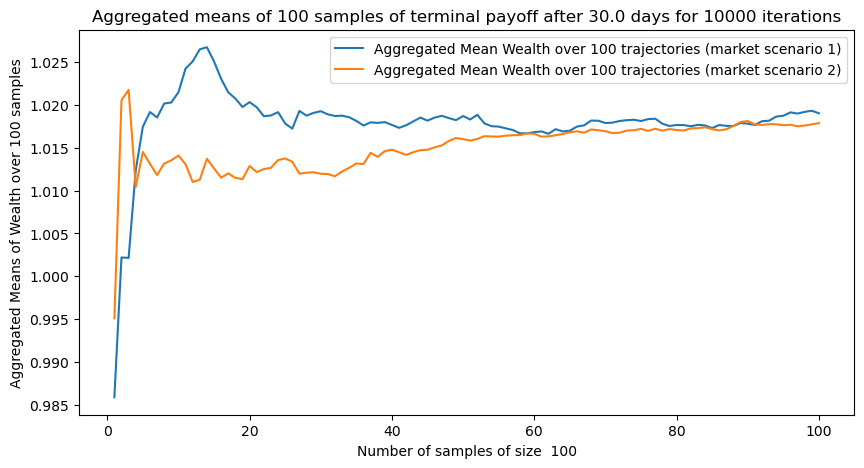

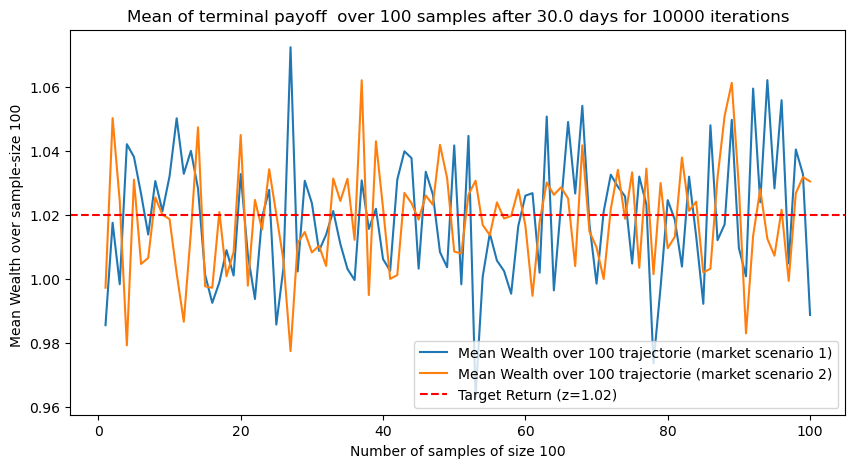

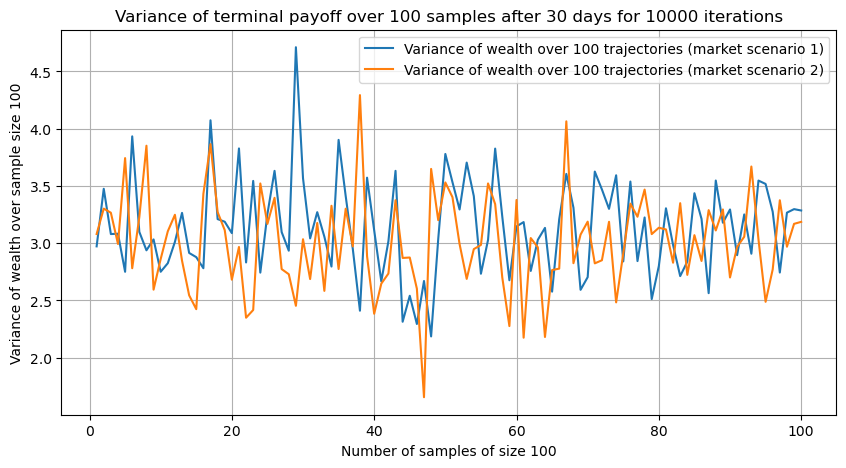

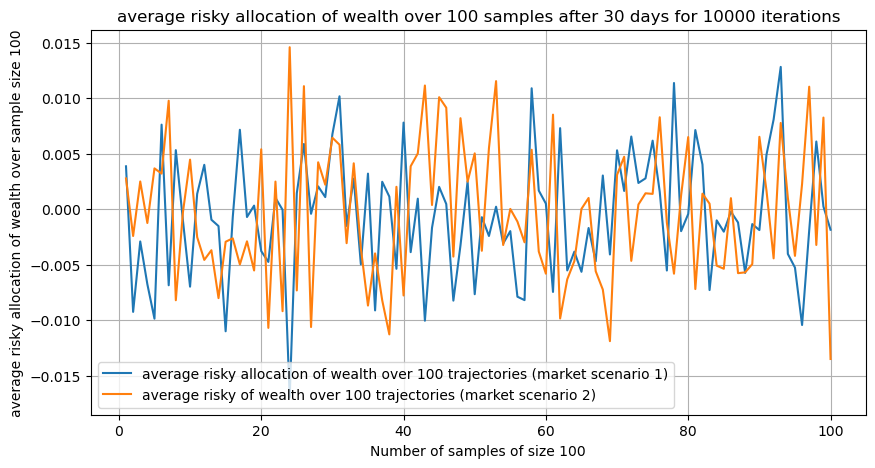

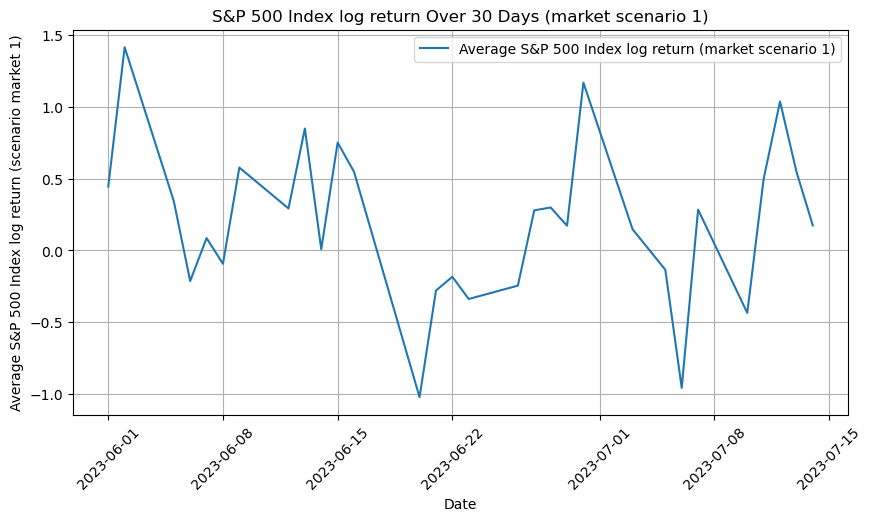

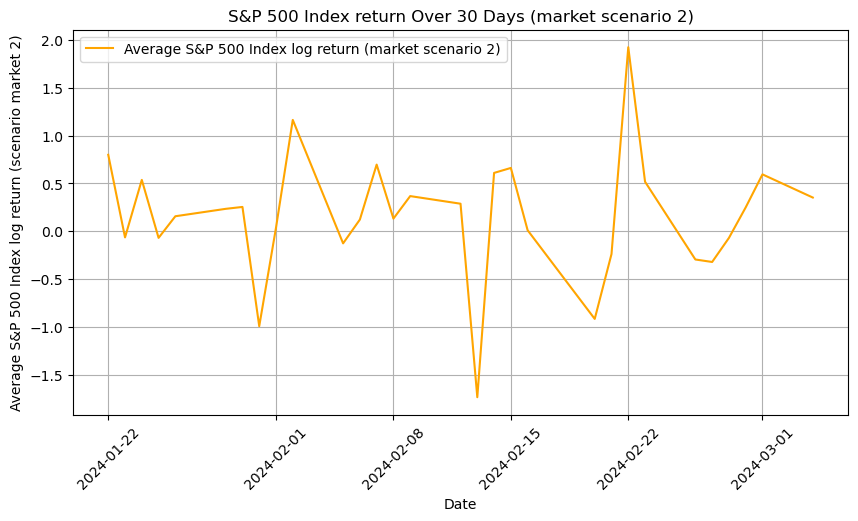

In [ ]:
#Market Scenario 1 

# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.000000005)   # (alpha, eta_kappa, eta_phi)
exploration_rate = 3 #lambda
num_iterations = 10000
sample_average_size = 100


#Market and Target parameters
initial_wealth = 1.0
target_payoff = 1.04
investment_horizon = 1
discretization_dt = 1/50 #number of days
interest_rate = 0.02
t=840
T = 880 # (delta_t) >= 1/discretization_dt !!!!!
market_return_plot_1 = market_log_returns[t:T]


#calling the function --------------------------------------------------------------
kappa, phi, w, payoff_mean_1, pay_off_mean_non_agg_1, variance_off_sample_1, ratio_risky_1, ratio_risky_over_time, value_sample = emv_portfolio_selection(
    market_return_plot_1, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
)

print("For Market Scenario 1")
print("Final Parameters:")
print("kappa:", kappa)
print("Phi:", phi)
print("w:", w)


#Market Scenario 2

# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.000000005)   # (alpha, eta_kappa, eta_phi)
exploration_rate = 3 #lambda
num_iterations = 10000
sample_average_size = 100


#Market and Target parameters
initial_wealth = 1
target_payoff = 1.04
investment_horizon = 1
discretization_dt = 1/50 #number of days
interest_rate = 0.02
t= 1000
T = 1040
market_return_plot_2 = market_log_returns[t:T]

kappa, phi, w, payoff_mean_2, pay_off_mean_non_agg_2, variance_off_sample_2, ratio_risky_2, ratio_risky_over_time,value_sample = emv_portfolio_selection(
    market_return_plot_2, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
)

print("For Market Scenario 2")
print("Final Parameters:")
print("kappa:", kappa)
print("Phi:", phi)
print("w:", w)


#--------------------------------------------Aggregated mean over the sample_average_size------------------------------------------------------------#
#PLOT Mean payoff

num_trajectories = list(range(1, len(payoff_mean_1) + 1))  # X-axis: trajectory indices

plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, payoff_mean_1, linestyle='-', label=f'Aggregated Mean Wealth over {sample_average_size} trajectories (market scenario 1)')
plt.plot(num_trajectories, payoff_mean_2, linestyle='-', label=f'Aggregated Mean Wealth over {sample_average_size} trajectories (market scenario 2)')

plt.xlabel(f"Number of samples of size  {int(sample_average_size)}")
plt.ylabel(f"Aggregated Means of Wealth over {int(sample_average_size)} samples")
plt.title(f"Aggregated means of {int(sample_average_size)} samples of terminal payoff after {1/discretization_dt} days for {num_iterations} iterations")
plt.legend()

#--------------------------------------------Non aggregated mean over the sample_average_size------------------------------------------------------------#

#PLOT Mean payoff

num_trajectories = list(range(1, len(pay_off_mean_non_agg_1) + 1))  # X-axis: trajectory indices

plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, pay_off_mean_non_agg_1, linestyle='-', label=f'Mean Wealth over {sample_average_size} trajectorie (market scenario 1)')
plt.plot(num_trajectories, pay_off_mean_non_agg_2, linestyle='-', label=f'Mean Wealth over {sample_average_size} trajectorie (market scenario 2)')

plt.axhline(y=target_payoff, color='r', linestyle='--', label=f'Target Return (z={target_payoff})')

plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Mean Wealth over sample-size {int(sample_average_size)} ")
plt.title(f"Mean of terminal payoff  over {int(sample_average_size)} samples after {1/discretization_dt} days for {num_iterations} iterations")
plt.legend()


#--------------------------------------------Variance over the sample_average_size------------------------------------------------------------#

#PLOT Mean payoff

num_trajectories = list(range(1, len(variance_off_sample_1) + 1))


plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, variance_off_sample_1, linestyle='-', label=f'Variance of wealth over {sample_average_size} trajectories (market scenario 1)')
plt.plot(num_trajectories, variance_off_sample_2, linestyle='-', label=f'Variance of wealth over {sample_average_size} trajectories (market scenario 2)')


plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Variance of wealth over sample size {int(sample_average_size)}")
plt.title(f"Variance of terminal payoff over {int(sample_average_size)} samples after {int(1/discretization_dt)} days for {num_iterations} iterations")
plt.legend()
plt.grid(True)  # Improves readability
plt.show()


#--------------------------------------------mean of risky  allocations  over the sample_average_size------------------------------------------------------------#

num_trajectories = list(range(1,len(ratio_risky_1) +1))
plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, ratio_risky_1, linestyle='-', label=f'average risky allocation of wealth over {sample_average_size} trajectories (market scenario 1)')
plt.plot(num_trajectories, ratio_risky_2, linestyle='-', label=f'average risky of wealth over {sample_average_size} trajectories (market scenario 2)')

plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"average risky allocation of wealth over sample size {int(sample_average_size)}")
plt.title(f"average risky allocation of wealth over {int(sample_average_size)} samples after {int(1/discretization_dt)} days for {num_iterations} iterations")
plt.legend()
plt.grid(True)  # Improves readability
plt.show()



#-------------------------------------S&P 500 plotting---------------------------------------------------------------------------------------------#


#Market scenario 1 
market_av_30 = market_return_plot_1[:int(1/discretization_dt)]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(market_av_30.index, market_av_30.values, linestyle='-', label="Average S&P 500 Index log return (market scenario 1)")

# Formatting
plt.xlabel("Date")
plt.ylabel("Average S&P 500 Index log return (scenario market 1)")
plt.title(f"S&P 500 Index log return Over {int(1/discretization_dt)} Days (market scenario 1)")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.legend()
plt.show()

#Market scenario 2
market_av_30 = market_return_plot_2[:int(1/discretization_dt)]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(market_av_30.index, market_av_30.values, linestyle='-', label="Average S&P 500 Index log return (market scenario 2)", color = "orange")

# Formatting
plt.xlabel("Date")
plt.ylabel("Average S&P 500 Index log return (scenario market 2)")
plt.title(f"S&P 500 Index return Over {int(1/discretization_dt)} Days (market scenario 2)")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.legend()
plt.show()


In [137]:
#Market Scenario 3

#Tuning hyperparameters

# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.000000005)   # (alpha, eta_gamma, eta_phi)
num_iterations = 15000
sample_average_size = 100


#Market and Target parameters
initial_wealth = 1.0
target_payoff = 1.05
investment_horizon = 1
discretization_dt = 1/30 #number of days
interest_rate = 0.02
t = 700
T = 740
market_return_plot_3 = market_log_returns[t:T]

#call for lambda = 1 
exploration_rate1 = 1 #lambda

kappa, phi, w, payoff_mean_1, pay_off_mean_non_agg_1, variance_off_sample_1, ratio_risky_1, ratio_risky_over_time, value_sample = emv_portfolio_selection(
    market_return_plot_3, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate1, 
    num_iterations, sample_average_size, interest_rate
)

print("For Market Scenario 3")
print("Final Parameters:")
print("kappa:", kappa)
print("Phi:", phi)
print("w:", w)

#call for lambda = 2 
exploration_rate2 = 2
kappa, phi, w, payoff_mean_2, pay_off_mean_non_agg_2, variance_off_sample_2, ratio_risky_2, ratio_risky_over_time,value_sample = emv_portfolio_selection(
    market_return_plot_3, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate2, 
    num_iterations, sample_average_size, interest_rate
)



print("For Market Scenario 3")
print("Final Parameters:")
print("kappa:", kappa)
print("Phi:", phi)
print("w:", w)

#call for lambda = 3 
exploration_rate3 = 3
kappa, phi, w, payoff_mean_3, pay_off_mean_non_agg_3, variance_off_sample_3, ratio_risky_3, ratio_risky_over_time,value_sample = emv_portfolio_selection(
    market_return_plot_3, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate3, 
    num_iterations, sample_average_size, interest_rate
)

print("For Market Scenario 3")
print("Final Parameters:")
print("kappa:", kappa)
print("Phi:", phi)
print("w:", w)


#--------------------------------------------Aggregated mean over the sample_average_size------------------------------------------------------------#
#PLOT Mean payoff

num_trajectories = list(range(1, len(payoff_mean_1) + 1))  # X-axis: trajectory indices

plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, payoff_mean_1, linestyle='-', label=f'Aggregated Mean Wealth over {sample_average_size} trajectories for lambda = {exploration_rate1}')
plt.plot(num_trajectories, payoff_mean_2, linestyle='-', label=f'Aggregated Mean Wealth over {sample_average_size} trajectories for lambda = {exploration_rate2}')
plt.plot(num_trajectories, payoff_mean_3, linestyle='-', label=f'Aggregated Mean Wealth over {sample_average_size} trajectories for lambda = {exploration_rate3}')



plt.xlabel(f"Number of samples of size  {int(sample_average_size)}")
plt.ylabel(f"Aggregated Means of Wealth over {int(sample_average_size)} samples")
plt.title(f"Aggregated means of {int(sample_average_size)} samples of terminal payoff after {1/discretization_dt} days for {num_iterations} iterations")
plt.legend()

#--------------------------------------------Non aggregated mean over the sample_average_size------------------------------------------------------------#

#PLOT Mean payoff

num_trajectories = list(range(1, len(pay_off_mean_non_agg_1) + 1))  # X-axis: trajectory indices

plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, pay_off_mean_non_agg_1, linestyle='-', label=f'Mean Wealth over {sample_average_size} trajectorie for lambda = {exploration_rate1}')
plt.plot(num_trajectories, pay_off_mean_non_agg_2, linestyle='-', label=f'Mean Wealth over {sample_average_size} trajectorie for lambda ={exploration_rate2}')
plt.plot(num_trajectories, pay_off_mean_non_agg_3, linestyle='-', label=f'Mean Wealth over {sample_average_size} trajectorie for lambda = {exploration_rate3}')


plt.axhline(y=target_payoff, color='r', linestyle='--', label=f'Target Return (z={target_payoff})')

plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Mean Wealth over sample-size {int(sample_average_size)} ")
plt.title(f"Mean of terminal payoff  over {int(sample_average_size)} samples after {1/discretization_dt} days for {num_iterations} iterations")
plt.legend()


#--------------------------------------------Variance over the sample_average_size------------------------------------------------------------#

#PLOT Mean payoff

num_trajectories = list(range(1, len(variance_off_sample_1) + 1))


plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, variance_off_sample_1, linestyle='-', label=f'Variance of wealth over {sample_average_size} trajectories for lambda = {exploration_rate1}')
plt.plot(num_trajectories, variance_off_sample_2, linestyle='-', label=f'Variance of wealth over {sample_average_size} trajectories for lambda = {exploration_rate2}')
plt.plot(num_trajectories, variance_off_sample_3, linestyle='-', label=f'Variance of wealth over {sample_average_size} trajectories for lambda = {exploration_rate3}')



plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Variance of wealth over sample size {int(sample_average_size)}")
plt.title(f"Variance of terminal payoff over {int(sample_average_size)} samples after {int(1/discretization_dt)} days for {num_iterations} iterations")
plt.legend()
plt.show()


#--------------------------------------------mean of risky  allocations  over the sample_average_size------------------------------------------------------------#

num_trajectories = list(range(1,len(ratio_risky_1) +1))
plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, ratio_risky_1, linestyle='-', label=f'average risky allocation  for lambda =  {exploration_rate1}')
plt.plot(num_trajectories, ratio_risky_2, linestyle='-', label=f'average risky allocation for lambda = {exploration_rate2}')
plt.plot(num_trajectories, ratio_risky_3, linestyle='-', label=f'average risky allocation for lambda = {exploration_rate3}')

plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"average risky allocation of wealth over sample size {int(sample_average_size)}")
plt.title(f"average risky allocation of wealth over {int(sample_average_size)} samples after {int(1/discretization_dt)} days for {num_iterations} iterations")
plt.legend()
plt.show()


#Market scenario 3
market_av_30 = market_return_plot_3[:int(1/discretization_dt)]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(market_av_30.index, market_av_30.values, linestyle='-', label="Average S&P 500 Index log return (market scenario 3)", color = "green")

# Formatting
plt.xlabel("Date")
plt.ylabel("Average S&P 500 Index log return (market scenario 3)")
plt.title(f"S&P 500 Index log return Over {int(1/discretization_dt)} Days (market scenario 3)")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.legend()
plt.show()

KeyboardInterrupt: 

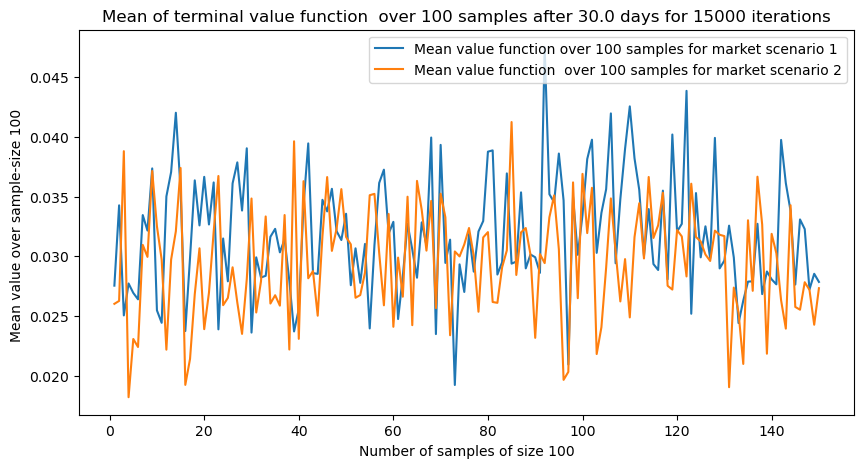

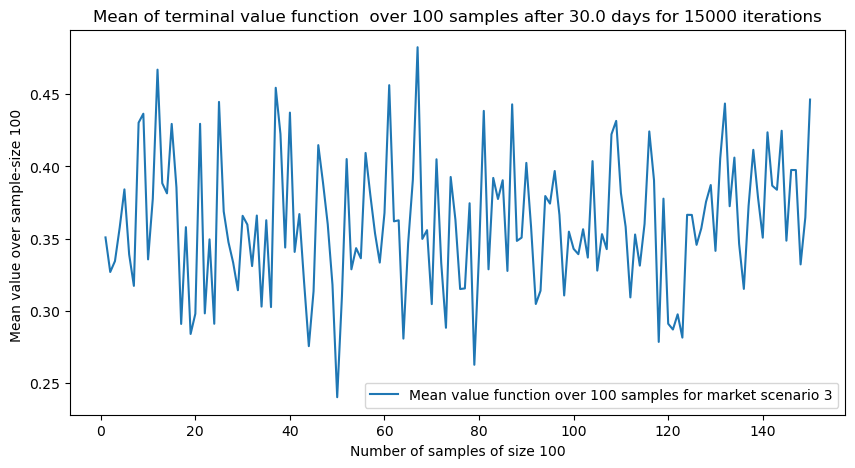

In [138]:
#Market Scenario 1 

# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.000000005)   # (alpha, eta_kappa, eta_phi)
exploration_rate = 3 #lambda
num_iterations = 15000
sample_average_size = 100


#Market and Target parameters
initial_wealth = 1.0
target_payoff = 1.05
investment_horizon = 1
discretization_dt = 1/30 #number of days
interest_rate = 0.02
t=840
T = 880 # (delta_t) >= 1/discretization_dt !!!!!
market_return_plot_1 = market_log_returns[t:T]


#calling the function --------------------------------------------------------------
kappa, phi, w, payoff_mean_1, pay_off_mean_non_agg_1, variance_off_sample_1, ratio_risky_1, ratio_risky_over_time, value_sample1 = emv_portfolio_selection(
    market_return_plot_1, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
)

#Market Scenario 2

# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.000000005)   # (alpha, eta_kappa, eta_phi)
exploration_rate = 3 #lambda
num_iterations = 15000
sample_average_size = 100


#Market and Target parameters
initial_wealth = 1
target_payoff = 1.05
investment_horizon = 1
discretization_dt = 1/30 #number of days
interest_rate = 0.02
t= 1000
T = 1040
market_return_plot_2 = market_log_returns[t:T]

kappa, phi, w, payoff_mean_2, pay_off_mean_non_agg_2, variance_off_sample_2, ratio_risky_2, ratio_risky_over_time,value_sample2 = emv_portfolio_selection(
    market_return_plot_2, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
)



#Market Scenario 3

#Tuning hyperparameters

# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.000000005)   # (alpha, eta_gamma, eta_phi)
num_iterations = 15000
sample_average_size = 100


#Market and Target parameters
initial_wealth = 1.0
target_payoff = 1.05
investment_horizon = 1
discretization_dt = 1/30 #number of days
interest_rate = 0.02
t = 700
T = 740
market_return_plot_3 = market_log_returns[t:T]

#call for lambda = 1 
exploration_rate1 = 1 #lambda

kappa, phi, w, payoff_mean_1, pay_off_mean_non_agg_1, variance_off_sample_1, ratio_risky_1, ratio_risky_over_time,value_sample3 = emv_portfolio_selection(
    market_return_plot_3, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate1, 
    num_iterations, sample_average_size, interest_rate
)


#Plotting market scenario 1 and 2 
num_trajectories = list(range(1, len(value_sample1) + 1))  # X-axis: trajectory indices

plt.figure(figsize=(10, 5))

plt.plot(num_trajectories, value_sample1, linestyle='-', label=f'Mean value function over {sample_average_size} samples for market scenario 1')
plt.plot(num_trajectories, value_sample2, linestyle='-', label=f'Mean value function  over {sample_average_size} samples for market scenario 2')

plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Mean value over sample-size {int(sample_average_size)} ")
plt.title(f"Mean of terminal value function  over {int(sample_average_size)} samples after {1/discretization_dt} days for {num_iterations} iterations")
plt.legend()
plt.show()



# Plotting market scenario 3 
plt.figure(figsize=(10, 5))
plt.plot(num_trajectories, value_sample3, linestyle='-', label=f'Mean value function over {sample_average_size} samples for market scenario 3')
plt.xlabel(f"Number of samples of size {int(sample_average_size)}")
plt.ylabel(f"Mean value over sample-size {int(sample_average_size)} ")
plt.title(f"Mean of terminal value function  over {int(sample_average_size)} samples after {1/discretization_dt} days for {num_iterations} iterations")
plt.legend()
plt.show()



For Market Scenario 1
Final Parameters:
kappa: [-0.0016577091838198197, 0.0002404130078592184, 0.00011619917887569394, 0.19921299092880587]
Phi: [-0.0007212390235776689, 0.09960649415072638]
w: 1.0848180979399813
For Market Scenario 3
Final Parameters:
kappa: [-0.002926511987449152, -0.00018358315299481955, -0.0001529464726786647, 0.2059327960976018]
Phi: [0.00018358315299481955, 0.10296640855198806]
w: 1.0984709027190147


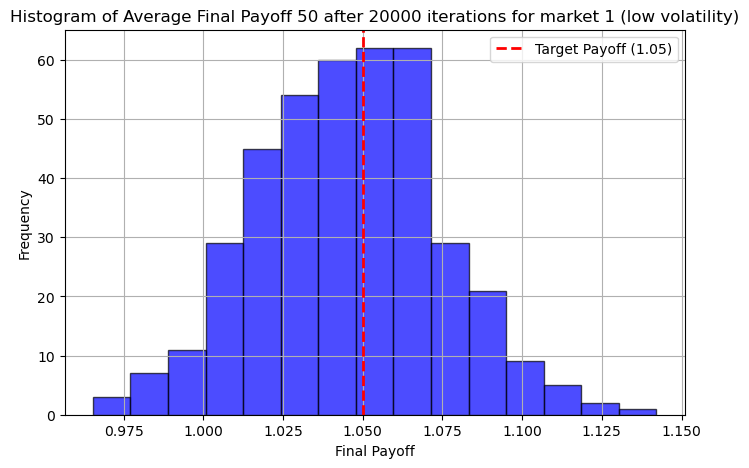

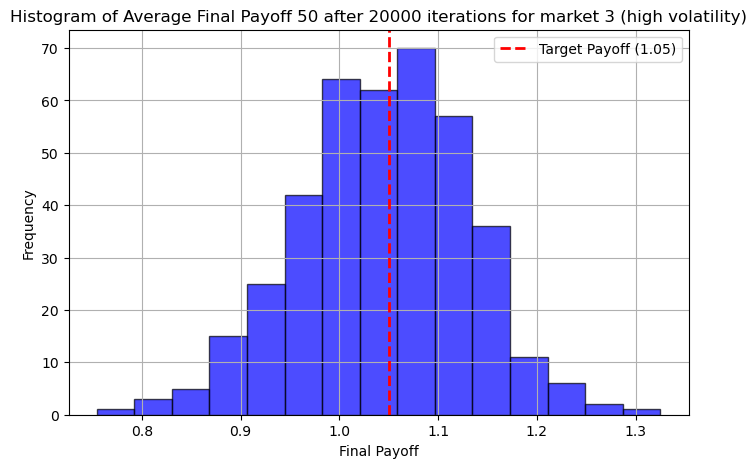

In [ ]:
#Market Scenario 1 

# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.000000005)   # (alpha, eta_kappa, eta_phi)
exploration_rate = 3 #lambda
num_iterations = 20000
sample_average_size = 50


#Market and Target parameters
initial_wealth = 1.0
target_payoff = 1.05
investment_horizon = 1
discretization_dt = 1/30 #number of days
interest_rate = 0.02
t=840
T = 880 # (delta_t) >= 1/discretization_dt !!!!!
market_return_plot_1 = market_log_returns[t:T]


#calling the function --------------------------------------------------------------
kappa, phi, w, payoff_mean_1, pay_off_mean_non_agg_1, variance_off_sample_1, ratio_risky_1, ratio_risky_over_time, value_sample= emv_portfolio_selection(
    market_return_plot_1, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
)

print("For Market Scenario 1")
print("Final Parameters:")
print("kappa:", kappa)
print("Phi:", phi)
print("w:", w)

#Market scenario 3 
[]
# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.000000005)   # (alpha, eta_gamma, eta_phi)
exploration_rate1 = 1 #lambda
num_iterations = 20000
sample_average_size = 50

#Market and Target parameters
initial_wealth = 1.0
target_payoff = 1.05
investment_horizon = 1
discretization_dt = 1/30 #number of days
interest_rate = 0.02
t = 700
T = 740
market_return_plot_3 = market_log_returns[t:T]



kappa, phi, w, payoff_mean_1, pay_off_mean_non_agg_3, variance_off_sample_1, ratio_risky_1, ratio_risky_over_time,value_sample = emv_portfolio_selection(
    market_return_plot_3, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate1, 
    num_iterations, sample_average_size, interest_rate
)

print("For Market Scenario 3")
print("Final Parameters:")
print("kappa:", kappa)
print("Phi:", phi)
print("w:", w)


#Market 1
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(pay_off_mean_non_agg_1, bins=15, color='blue', alpha=0.7, edgecolor='black')

# Add vertical line for target payoff
plt.axvline(target_payoff, color='red', linestyle='dashed', linewidth=2, label=f"Target Payoff ({target_payoff})")

# Labels and title
plt.xlabel("Final Payoff")
plt.ylabel("Frequency")
plt.title(f'Histogram of Average Final Payoff for sample size {sample_average_size} after {num_iterations} iterations for market 1 (low volatility)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

#Market 3 
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(pay_off_mean_non_agg_3, bins=15, color='blue', alpha=0.7, edgecolor='black')

# Add vertical line for target payoff
plt.axvline(target_payoff, color='red', linestyle='dashed', linewidth=2, label=f"Target Payoff ({target_payoff})")

# Labels and title
plt.xlabel("Final Payoff")
plt.ylabel("Frequency")
plt.title(f'Histogram of Average Final Payoff for sample size {sample_average_size} after {num_iterations} iterations for market 3 (high volatility)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

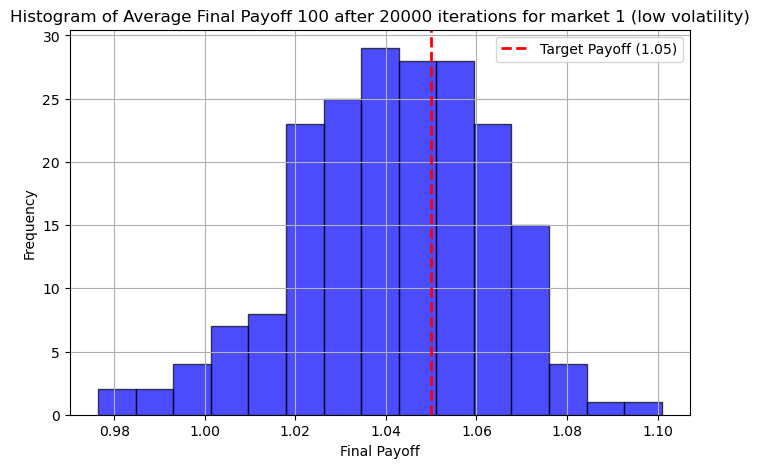

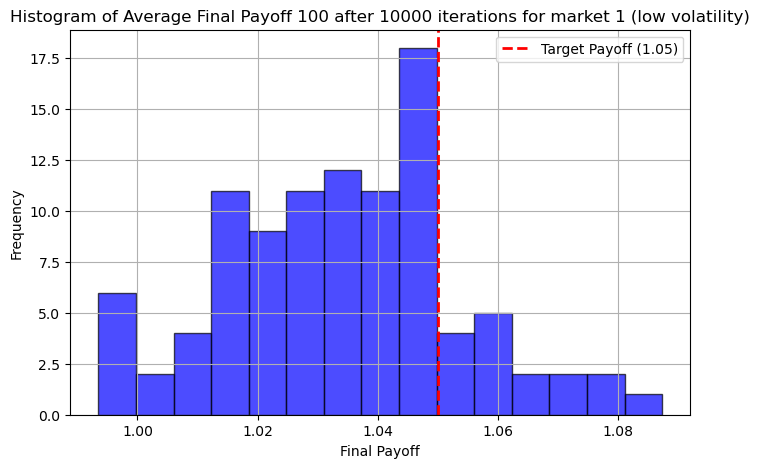

In [ ]:
#Compare terminal wealth after 10000 iterations and 20 000 iterations on histogram (low volatility market)

# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.000000005)   # (alpha, eta_kappa, eta_phi)
exploration_rate = 3 #lambda
num_iterations = 20000
sample_average_size = 100


#Market and Target parameters
initial_wealth = 1.0
target_payoff = 1.05
investment_horizon = 1
discretization_dt = 1/30 #number of days
interest_rate = 0.02
t=840
T = 880 # (delta_t) >= 1/discretization_dt !!!!!
market_return_plot_1 = market_log_returns[t:T]


#calling the function --------------------------------------------------------------
kappa, phi, w, payoff_mean_1, pay_off_mean_non_agg_1, variance_off_sample_1, ratio_risky_1, ratio_risky_over_time, value_sample = emv_portfolio_selection(
    market_return_plot_1, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
)

#Market 1
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(pay_off_mean_non_agg_1, bins=15, color='blue', alpha=0.7, edgecolor='black')

# Add vertical line for target payoff
plt.axvline(target_payoff, color='red', linestyle='dashed', linewidth=2, label=f"Target Payoff ({target_payoff})")

# Labels and title
plt.xlabel("Final Payoff")
plt.ylabel("Frequency")
plt.title(f'Histogram of Average Final Payoff for sample size {sample_average_size} after {num_iterations} iterations for market 1 (low volatility)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()




# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.000000005)   # (alpha, eta_kappa, eta_phi)
exploration_rate = 3 #lambda
num_iterations = 10000
sample_average_size = 100


#Market and Target parameters
initial_wealth = 1.0
target_payoff = 1.05
investment_horizon = 1
discretization_dt = 1/30 #number of days
interest_rate = 0.02
t=840
T = 880 # (delta_t) >= 1/discretization_dt !!!!!
market_return_plot_1 = market_log_returns[t:T]


#calling the function --------------------------------------------------------------
kappa, phi, w, payoff_mean_1, pay_off_mean_non_agg_1, variance_off_sample_1, ratio_risky_1, ratio_risky_over_time, value_sample = emv_portfolio_selection(
    market_return_plot_1, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
)

#Market 1
# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(pay_off_mean_non_agg_1, bins=15, color='blue', alpha=0.7, edgecolor='black')

# Add vertical line for target payoff
plt.axvline(target_payoff, color='red', linestyle='dashed', linewidth=2, label=f"Target Payoff ({target_payoff})")

# Labels and title
plt.xlabel("Final Payoff")
plt.ylabel("Frequency")
plt.title(f'Histogram of Average Final Payoff for sample size {sample_average_size} after {num_iterations} iterations for market 1 (low volatility)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()




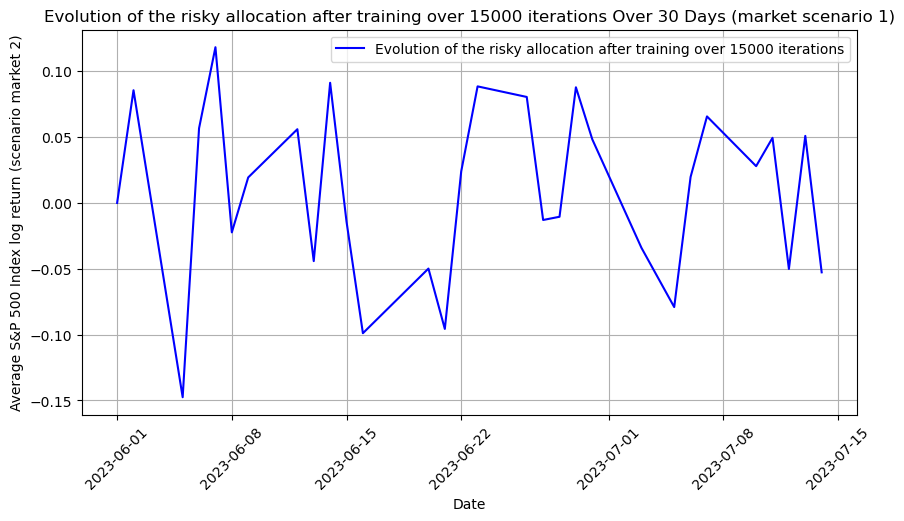

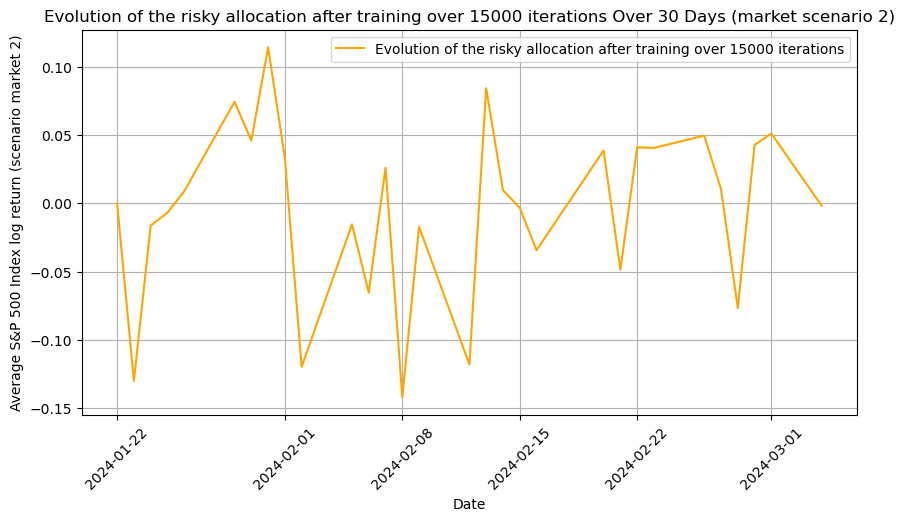

In [ ]:
#looking at the evolution of the ratio of risky asset over time


# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.000000005)   # (alpha, eta_kappa, eta_phi)
exploration_rate = 3 #lambda
num_iterations = 15000
sample_average_size = 100


#Market and Target parameters
initial_wealth = 1.0
target_payoff = 1.05
investment_horizon = 1
discretization_dt = 1/30 #number of days
interest_rate = 0.02

#Market scenario 1
t=840
T = 880 # (delta_t) >= 1/discretization_dt !!!!!
market_return_plot_1 = market_log_returns[t:T]


#calling the function --------------------------------------------------------------
kappa, phi, w, payoff_mean_1, pay_off_mean_non_agg_1, variance_off_sample_1, ratio_risky_1, ratio_risky_over_time,value_sample = emv_portfolio_selection(
    market_return_plot_1, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
)


#Market scenario 2
t= 1000
T = 1040
market_return_plot_2 = market_log_returns[t:T]

#calling the function --------------------------------------------------------------
kappa, phi, w, payoff_mean_1, pay_off_mean_non_agg_1, variance_off_sample_1, ratio_risky_1, ratio_risky_over_time2, value_sample = emv_portfolio_selection(
    market_return_plot_2, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate, 
    num_iterations, sample_average_size, interest_rate
)


#Plotting for market 1
market_av_30 = market_return_plot_1[:int(1/discretization_dt)]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(market_av_30.index, ratio_risky_over_time , linestyle='-', label=f"Evolution of the risky allocation after training over {num_iterations} iterations", color ="blue")

# Formatting
plt.xlabel("Date")
plt.ylabel("Risky allocation")
plt.title(f"Evolution of the risky allocation after training over {num_iterations} iterations over {int(1/discretization_dt)} Days (market scenario 1)")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.legend()
plt.show()

#Plotting for market 2
market_av_30 = market_return_plot_2[:int(1/discretization_dt)]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(market_av_30.index, ratio_risky_over_time2 , linestyle='-', label=f"Evolution of the risky allocation after training over {num_iterations} iterations", color = "orange")

# Formatting
plt.xlabel("Date")
plt.ylabel("Risky allocation")
plt.title(f"Evolution of the risky allocation after training over {num_iterations} iterations over {int(1/discretization_dt)} Days (market scenario 2)")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.legend()
plt.show()






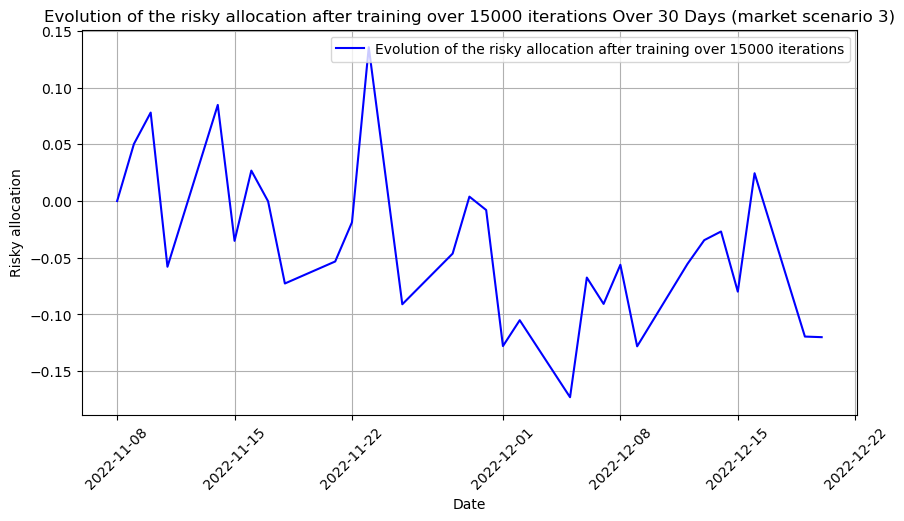

In [ ]:
#Risky allocation for market Scenario 3 over time (30 days)

#Tuning hyperparameters

# Hyperparameter tunning ----------------------------------------------------------
learning_rates = (0.05, 0.000000005, 0.000000005)   # (alpha, eta_gamma, eta_phi)
num_iterations = 15000
sample_average_size = 100


#Market and Target parameters
initial_wealth = 1.0
target_payoff = 1.05
investment_horizon = 1
discretization_dt = 1/30 #number of days
interest_rate = 0.02
t = 700
T = 740
market_return_plot_3 = market_log_returns[t:T]

#call for lambda = 1 
exploration_rate1 = 1 #lambda

kappa, phi, w, payoff_mean_1, pay_off_mean_non_agg_1, variance_off_sample_1, ratio_risky_1, ratio_risky_over_time,value_sample = emv_portfolio_selection(
    market_return_plot_3, learning_rates, initial_wealth, target_payoff, 
    investment_horizon, discretization_dt, exploration_rate1, 
    num_iterations, sample_average_size, interest_rate
)

#Plotting for market 1
market_av_30 = market_return_plot_3[:int(1/discretization_dt)]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(market_av_30.index, ratio_risky_over_time , linestyle='-', label=f"Evolution of the risky allocation after training over {num_iterations} iterations", color ="blue")

# Formatting
plt.xlabel("Date")
plt.ylabel("Risky allocation")
plt.title(f"Evolution of the risky allocation after training over {num_iterations} iterations Over {int(1/discretization_dt)} Days (market scenario 3)")
plt.xticks(rotation=45)  # Rotate dates for readability
plt.grid(True)
plt.legend()
plt.show()
